# Principes de la classification bayésienne

## Principes généraux
Dans la classification par le critère du maximum de vraisemblance on choisit une classe C qui maximise la vraisemblance P(x|C). Cette vraisemblance répresent la probabilité d'observer le donnée x sachant C, et cette méthode de classification suppose une probabilité a priori égale pour toutes les classes.
D'autre côté, dans la classification par le critère du maximum a posteriori on cherche un choix de C qui maximise la probabilité a posteriori P(C|x). Cette probabilité est obtenue par la formule de Bayes, et donc cette méthode de classification prend en compte la probabilité a priori des classes
Dans le programmes, on va utiliser une classification bayésienne pour la résolution du probléme des champignons dans les feuilles de ble. Cela est plus approprié, parce que on n'a pas une garantie que toutes les classes aient une même taux d'apparition dans le figures. C'est à dire, les fréquences des classes ne seront problablement pas uniformes, et donc une méthode qui prend en compte les probabilités a priori de chaque classe evite des biais causés par ce déséquilibre.

## Application à la classification bayésienne des pixels
On fait tourner Display_Components.py:

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [43]:
img_bgr=cv2.imread("/home/rodrigo/ENSTA/Reconnaissance/Images_Classif/Images_Classif/INRA_Ble-Champignon/02-U2A.png",-1)
(h,w,c) = img_bgr.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes x",c,"canaux")

Dimension de l'image : 775 lignes x 811 colonnes x 3 canaux


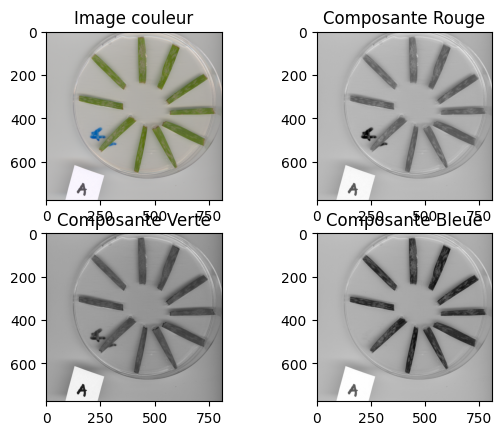

In [25]:
b,g,r = cv2.split(img_bgr) # On récupère les 3 composantes   
img_rgb = cv2.merge([r,g,b]) # Convention matplotlib  

#Affichage des composantes RGB
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(r,cmap = 'gray')
plt.title('Composante Rouge')
plt.subplot(223)
plt.imshow(g,cmap = 'gray')
plt.title('Composante Verte')
plt.subplot(224)
plt.imshow(b,cmap = 'gray')
plt.title('Composante Bleue')
plt.show()

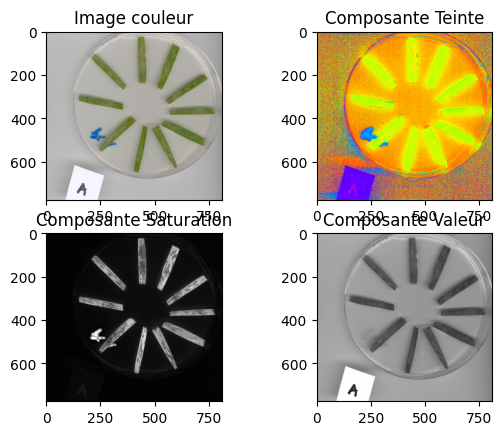

In [26]:
img_hsv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(img_hsv) # On récupère les 3 composantes

#Affichage des composantes HSV
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(h,cmap = 'hsv')
plt.title('Composante Teinte')
plt.subplot(223)
plt.imshow(s,cmap = 'gray')
plt.title('Composante Saturation')
plt.subplot(224)
plt.imshow(v,cmap = 'gray')
plt.title('Composante Valeur')
plt.show()

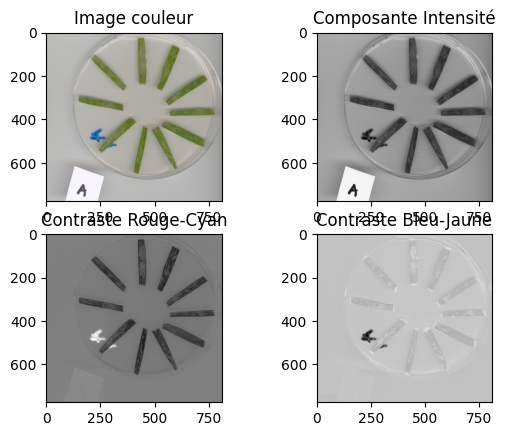

In [27]:
img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
y,cr,cb = cv2.split(img_yuv) # On récupère les 3 composantes

#Affichage des composantes YUV
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('Image couleur')
plt.subplot(222)
plt.imshow(y,cmap = 'gray')
plt.title('Composante Intensité')
plt.subplot(223)
plt.imshow(cr,cmap = 'gray')
plt.title('Contraste Rouge-Cyan')
plt.subplot(224)
plt.imshow(cb,cmap = 'gray')
plt.title('Contraste Bleu-Jaune')
plt.show()

L'utilisation de seules couleurs comme espace d'observation est limité par des variations dans l'image. Ces variations peuvent être, par exemple, ombres, reflets, couleaurs différents entre les images, etc.
Exemples d'autres caractéristiques qu'on pourait utiliser sont de texture, des composants fréquentielles, comme une transformée de Fourier, etc.
Par exemple, dans ce travail, on va utiliser le canal de contraste rouge-cyan de l'espace de couleur YUV pour segmenter dans l'image tout ce qui correspond à de feuilles. Ça sera fait dans la façon suivante:

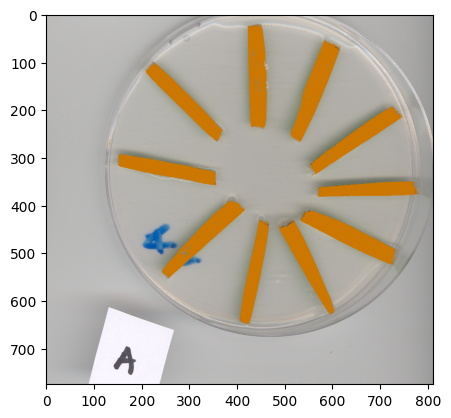

In [45]:
threshold_level = 116

coords = np.column_stack(np.where(cr < threshold_level))
mask = cr < threshold_level
img_masked = img_rgb.copy()
img_masked[mask] = (204, 119, 0)

plt.plot()
plt.imshow(img_masked)
plt.show()

On a choisit cette méthode parce que, dans cet espace de couleur, les feuilles sont plus sombre que le reste de l'image. Comme on veut isoler les feuilles, ça nous aide a établir un threshold pour délimiter les pixels qui répresentent les feuilles.
Pourtant, même si cette méthode marce avec toutes les images de feuilles de blé présents dans notre dataset, on ne peut pas dire qu'elle est généralisable pour tout type d'image pour ce problème. Comme nous avons dit avant, des variations dans les images peuvent rendre la masque obtenu ici incorrect, puis qu'on ne peut pas prévoir le comportament du contrast rouge-cyan face à ces variations.

# Classification de caractéristiques locales

## Classification bayésienne des pixels
Comme on a réussi à trouver une masque qui délimites les feuilles dans les images, on peut faire Bayes_Model_Training.py tourner dans le space d'observation RGB normalement. En plus, pour le même motif, on peut utiliser seulement 2 classes pour la classification, parce que, même si le modèle va classifier tout ce qui n'est pas de feuilles avec une des 2 classes (positif ou négatif), on va utiliser la masque pour prend en compte seulement ce qui est bien une feuille dans l'image. 
Une difficulté potentielle est que, dans certaines images, quelques pixels de la boîte de Petri sont bien dedans le limite du threshold de la masque, et donc ils seront considerés dans le calcul de la pourcentage de champignon. Cependant, on peut considérer que ça ne changera pas beaucoup les résultats, comme il y a une quantité petite de ces pixels.
La classification sera fait dans la façon suivante:

In [34]:
# Classification Bayésienne avec distribution gaussienne multidimensionnelle :
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
#Idem, avec indépendance par composantes (i.e. covariance diagonale)
from sklearn.naive_bayes import GaussianNB 

In [35]:
(h_img,w_img,c_img) = img_bgr.shape
print("Dimension de l'image :",h_img,"lignes x",w_img,"colonnes x",c_img,"canaux")
print("Type de l'image :",img_bgr.dtype)

Dimension de l'image : 775 lignes x 811 colonnes x 3 canaux
Type de l'image : uint8


In [36]:
# this function allows to draw a sample rectangle 
# and to get its coordinates in the training image
roi_defined = False
def define_ROI(event, x, y, flags, param):
	global r,c,w,h,roi_defined
	# if the left mouse button was clicked, 
	# record the starting ROI coordinates 
	if event == cv2.EVENT_LBUTTONDOWN:
		r, c = x, y
		roi_defined = False
	# if the left mouse button was released,
	# record the ROI coordinates and dimensions
	elif event == cv2.EVENT_LBUTTONUP:
		r2, c2 = x, y
		h = abs(r2-r)
		w = abs(c2-c)
		r = min(r,r2)
		c = min(c,c2)  
		roi_defined = True
		
# Cette fonction met à jour le modèle bayésien avec le
# batch de pixels (RoI) courant, et le label fourni
def update_GBModel(r,c,w,h,label):
	global img_bgr,clf,classes,data_features,data_labels,first
	roi_features = img_bgr[c:c+w, r:r+h]
	print("RoI_Features :",roi_features.shape)
	roi_labels = np.full((w, h), label)
	batch_features = np.reshape(roi_features,(-1,3))
	batch_labels = np.ravel(roi_labels)
	if first == 1:
		first = 0
		data_features = batch_features.copy()
		data_labels = batch_labels.copy()
	else:
		data_features = np.concatenate((data_features,batch_features),axis = 0)
		data_labels = np.concatenate((data_labels,batch_labels),axis = 0)	

clone = img_bgr.copy()
cv2.namedWindow("Training image")
cv2.setMouseCallback("Training image", define_ROI)
num_pos = 0
num_neg = 0
first = 1
# Choix du modèle
# Par défaut de prior, ceux-ci sont calculés par la proportion de données fournies
# Alternativement on peut fixer les priors par ex : priors = [0.3,0.7]
clf = QuadraticDiscriminantAnalysis(priors = None)
#clf = GaussianNB(priors = None)

classes = np.unique([-1, 1])
# keep looping until the 'q' key is pressed
while True:
	# display the image and wait for a keypress
	cv2.imshow("Training image",img_bgr)
	key = cv2.waitKey(1) & 0xFF
	# if the ROI is defined, draw it!
	if (roi_defined):
		# draw a green rectangle around the region of interest
		cv2.rectangle(img_bgr, (r,c), (r+h,c+w), (0, 255, 0), 2)
	# else reset the image...
	else:
		img_bgr = clone.copy()
	# if the 'p' key is pressed, record a positive batch sample
	if key == ord("p"):
		num_pos += 1
		update_GBModel(r,c,w,h,1)
		print("Batch positif n°",num_pos,"enregistré !")
	# if the 'n' key is pressed, record a positive batch sample
	if key == ord("n"):
		num_neg += 1
		update_GBModel(r,c,w,h,-1)
		print("Batch négatif n°",num_neg,"enregistré !")    	
	# if the 'q' key is pressed, break from the loop
	if key == ord("q"):
		break

RoI_Features : (15, 23, 3)
Batch positif n° 1 enregistré !
RoI_Features : (11, 17, 3)
Batch positif n° 2 enregistré !
RoI_Features : (12, 16, 3)
Batch positif n° 3 enregistré !
RoI_Features : (16, 7, 3)
Batch négatif n° 1 enregistré !
RoI_Features : (16, 7, 3)
Batch négatif n° 2 enregistré !
RoI_Features : (10, 12, 3)
Batch négatif n° 3 enregistré !
RoI_Features : (12, 10, 3)
Batch négatif n° 4 enregistré !


Dimension des features : (1188, 3)
Dimension des labels : (1188,)
Type de l'image de label : int64
Champignon Percentage :  32.23179773144921 %


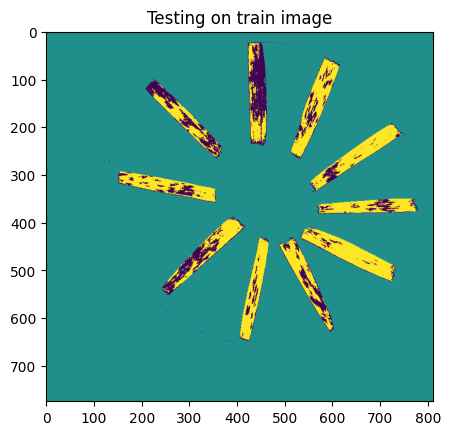

In [44]:
# First fit the whole data to the model
print("Dimension des features :",data_features.shape)
print("Dimension des labels :",data_labels.shape)
clf.fit(data_features,data_labels)  

# Test the prediction on the whole image
img_bgr = clone.copy()
img_samples = np.reshape(img_bgr,(-1,3))
img_labels = clf.predict(img_samples)
img_result = np.reshape(img_labels,(h_img,w_img))
print("Type de l'image de label :",img_result.dtype)

img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
_,cr,_ = cv2.split(img_yuv)
threshold_level = 116
coords_background = np.column_stack(np.where(cr > threshold_level))

img_result[np.where(img_result == 1)] = 255
img_result[np.where(img_result == -1)] = 0
for coord in coords_background:
	img_result[coord[0]][coord[1]] = 127
img_result = img_result.astype(np.uint8)

coords_leafs = np.column_stack(np.where(cr < threshold_level))
positive = 0
negative = 0
for coord in coords_leafs:
	if img_result[coord[0]][coord[1]] == 255:
		positive += 1
	else:
		negative += 1

print("Champignon Percentage : ", (negative/(positive + negative)) * 100, "%")
plt.plot()
plt.imshow(img_result)
plt.title("Testing on train image")
plt.show()



Type de l'image de label : int64
Champignon Percentage :  36.661308063287926 %


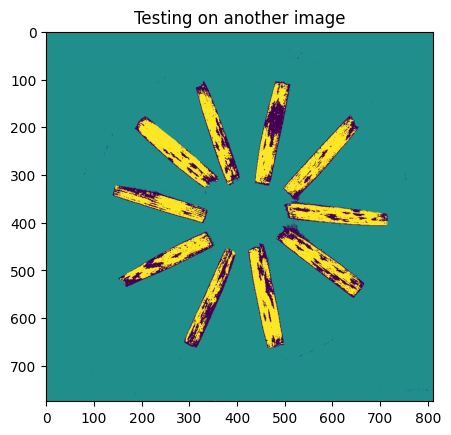

In [40]:
# Test the prediction on another image
img_bgr = cv2.imread("/home/rodrigo/ENSTA/Reconnaissance/Images_Classif/Images_Classif/INRA_Ble-Champignon/02-U2C.png",-1)
img_samples = np.reshape(img_bgr,(-1,3))
img_labels = clf.predict(img_samples)
img_result = np.reshape(img_labels,(h_img,w_img))
print("Type de l'image de label :",img_result.dtype)

img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
_,cr,_ = cv2.split(img_yuv)
threshold_level = 116
coords_background = np.column_stack(np.where(cr > threshold_level))

img_result[np.where(img_result == 1)] = 255
img_result[np.where(img_result == -1)] = 0
for coord in coords_background:
	img_result[coord[0]][coord[1]] = 127
img_result = img_result.astype(np.uint8)

coords_leafs = np.column_stack(np.where(cr < threshold_level))
positive = 0
negative = 0
for coord in coords_leafs:
	if img_result[coord[0]][coord[1]] == 255:
		positive += 1
	else:
		negative += 1

print("Champignon Percentage : ", (negative/(positive + negative)) * 100, "%")
plt.plot()
plt.imshow(img_result)
plt.title("Testing on another image")
plt.show()

Le modèle avec gaussien multidimensionnel calcule une covariance complète, en prennant en compte les corrélation entre les caractéristiques. D'autre côté, le modèle avec gaussien naïf calcule une covariance diagonale, en sopposant que les caractéristiques sont indépendantes. On peut faire tourner l'algorithme avec l'approche naïf:

In [46]:
# this function allows to draw a sample rectangle 
# and to get its coordinates in the training image
roi_defined = False
def define_ROI(event, x, y, flags, param):
	global r,c,w,h,roi_defined
	# if the left mouse button was clicked, 
	# record the starting ROI coordinates 
	if event == cv2.EVENT_LBUTTONDOWN:
		r, c = x, y
		roi_defined = False
	# if the left mouse button was released,
	# record the ROI coordinates and dimensions
	elif event == cv2.EVENT_LBUTTONUP:
		r2, c2 = x, y
		h = abs(r2-r)
		w = abs(c2-c)
		r = min(r,r2)
		c = min(c,c2)  
		roi_defined = True
		
# Cette fonction met à jour le modèle bayésien avec le
# batch de pixels (RoI) courant, et le label fourni
def update_GBModel(r,c,w,h,label):
	global img_bgr,clf,classes,data_features,data_labels,first
	roi_features = img_bgr[c:c+w, r:r+h]
	print("RoI_Features :",roi_features.shape)
	roi_labels = np.full((w, h), label)
	batch_features = np.reshape(roi_features,(-1,3))
	batch_labels = np.ravel(roi_labels)
	if first == 1:
		first = 0
		data_features = batch_features.copy()
		data_labels = batch_labels.copy()
	else:
		data_features = np.concatenate((data_features,batch_features),axis = 0)
		data_labels = np.concatenate((data_labels,batch_labels),axis = 0)	

clone = img_bgr.copy()
cv2.namedWindow("Training image")
cv2.setMouseCallback("Training image", define_ROI)
num_pos = 0
num_neg = 0
first = 1
# Choix du modèle
# Par défaut de prior, ceux-ci sont calculés par la proportion de données fournies
# Alternativement on peut fixer les priors par ex : priors = [0.3,0.7]
clf = GaussianNB(priors = None)
#clf = GaussianNB(priors = None)

classes = np.unique([-1, 1])
# keep looping until the 'q' key is pressed
while True:
	# display the image and wait for a keypress
	cv2.imshow("Training image",img_bgr)
	key = cv2.waitKey(1) & 0xFF
	# if the ROI is defined, draw it!
	if (roi_defined):
		# draw a green rectangle around the region of interest
		cv2.rectangle(img_bgr, (r,c), (r+h,c+w), (0, 255, 0), 2)
	# else reset the image...
	else:
		img_bgr = clone.copy()
	# if the 'p' key is pressed, record a positive batch sample
	if key == ord("p"):
		num_pos += 1
		update_GBModel(r,c,w,h,1)
		print("Batch positif n°",num_pos,"enregistré !")
	# if the 'n' key is pressed, record a positive batch sample
	if key == ord("n"):
		num_neg += 1
		update_GBModel(r,c,w,h,-1)
		print("Batch négatif n°",num_neg,"enregistré !")    	
	# if the 'q' key is pressed, break from the loop
	if key == ord("q"):
		break

RoI_Features : (14, 17, 3)
Batch positif n° 1 enregistré !
RoI_Features : (15, 12, 3)
Batch positif n° 2 enregistré !
RoI_Features : (9, 13, 3)
Batch positif n° 3 enregistré !
RoI_Features : (18, 7, 3)
Batch négatif n° 1 enregistré !
RoI_Features : (9, 8, 3)
Batch négatif n° 2 enregistré !
RoI_Features : (7, 8, 3)
Batch négatif n° 3 enregistré !


Dimension des features : (789, 3)
Dimension des labels : (789,)
Type de l'image de label : int64
Champignon Percentage :  37.10949876433686 %


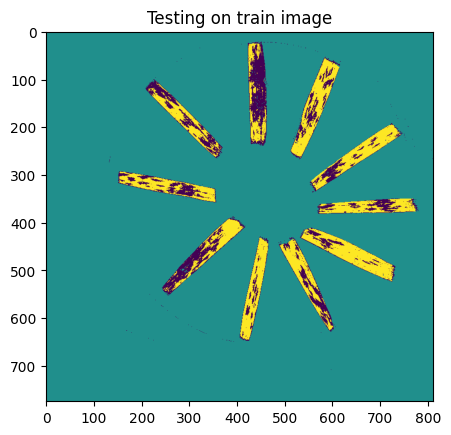

In [47]:
# First fit the whole data to the model
print("Dimension des features :",data_features.shape)
print("Dimension des labels :",data_labels.shape)
clf.fit(data_features,data_labels)  

# Test the prediction on the whole image
img_bgr = clone.copy()
img_samples = np.reshape(img_bgr,(-1,3))
img_labels = clf.predict(img_samples)
img_result = np.reshape(img_labels,(h_img,w_img))
print("Type de l'image de label :",img_result.dtype)

img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
_,cr,_ = cv2.split(img_yuv)
threshold_level = 116
coords_background = np.column_stack(np.where(cr > threshold_level))

img_result[np.where(img_result == 1)] = 255
img_result[np.where(img_result == -1)] = 0
for coord in coords_background:
	img_result[coord[0]][coord[1]] = 127
img_result = img_result.astype(np.uint8)

coords_leafs = np.column_stack(np.where(cr < threshold_level))
positive = 0
negative = 0
for coord in coords_leafs:
	if img_result[coord[0]][coord[1]] == 255:
		positive += 1
	else:
		negative += 1

print("Champignon Percentage : ", (negative/(positive + negative)) * 100, "%")
plt.plot()
plt.imshow(img_result)
plt.title("Testing on train image")
plt.show()



On rémarque qu'on obtient un résultat proche, mais legèrement moins précis. L'approche naïf est plus efficace, mais le résultat de l'approche multidimensionnel est plus precis vu qu'on a des variables corrélées.

## Classification non supervisée des pixels par K-Means
Le space d'observation est pareil à celui de la classification bayésienne, c'est à dire, les couleurs plus une masque. On assume qu'on purait diminuer le nombre de classes (initialement 6), comme l'image n'est pas trop complèxe, mais on doit le vérifier en faisant tourner avec differents valeurs de Nb_classes.
Un défi potenciel est le fait que le K-Means peut converger vers un optimum locaux, à cause de sa sensibilité aux valeurs initiales. Une autre possible difficulté est de trouver quels clusters trouvés par le K-Means correspondent aux feuilles, et aussi lequels entre les deux correspondent à chaque partie de la feuille (sans e avec champignon).
Les avantages sont que le K-Mean est plus rapide et pratique, parce qu'il est non supervisé et donc il n'y a pas besoin le labels. Cependant, les inconvénients sont qu'il est moins robuste et aussi qu'il y a moins de contrôle sur les classes.
On fait tourner KMeans_Clustering initialement avec 4 classes:

In [1]:
from sklearn.cluster import KMeans

In [5]:
(h_img,w_img,c) = img_bgr.shape
print("Dimension de l'image :",h_img,"lignes x",w_img,"colonnes x",c,"canaux")
print("Type de l'image :",img_bgr.dtype)

Dimension de l'image : 775 lignes x 811 colonnes x 3 canaux
Type de l'image : uint8


In [15]:
Nb_classes = 4

Centres des clusters :  [[176.43382952 179.95702483 181.61607534]
 [ 60.82508265 118.2564879  103.55073291]
 [251.19771138 243.138931   247.19096288]
 [151.34677393 158.23402222 158.3879709 ]]
Type de l'image de label : int32


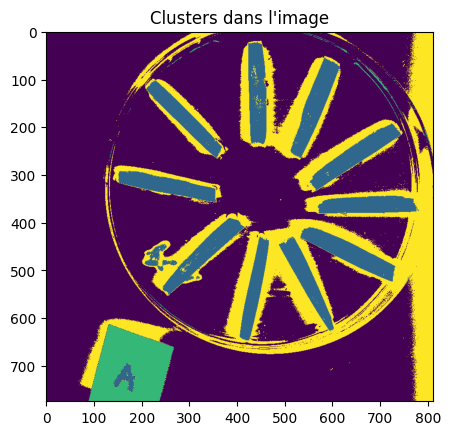

In [ ]:
def kmeans():
    # Création des clusters (entraînement) sur une image
    img_samples = np.reshape(img_bgr,(-1,3))
    kmeans = KMeans(n_clusters=Nb_classes, random_state=0).fit(img_samples)
    # Affichage des centres de cluster 
    print("Centres des clusters : ",kmeans.cluster_centers_)
    # Affichage des labels dans l'image d'entraînement
    img_labels = np.reshape(kmeans.labels_,(h_img,w_img))
    print("Type de l'image de label :",img_labels.dtype)
    # Normalisation pour affichage
    img_labels_display = (img_labels*255)/(Nb_classes - 1)
    img_labels_display = img_labels_display.astype(np.uint8)

    plt.plot()
    plt.imshow(img_labels_display)
    plt.title("Clusters dans l'image")
    plt.show()

kmeans()

On voit clairement que 4 classes ne sont pas sufisants pour le problème, parce qu'il n'y a pas de différenciation entre les parties sans e avec champignon dans les feuilles. Donc, on le tourne d'autres fois en augmentant le nombre de classes:

Centres des clusters :  [[165.94223213 171.48483664 173.32462288]
 [ 58.07098633 117.95167964 103.32504751]
 [252.18038371 243.84245855 247.86760507]
 [141.00453758 149.16866595 147.37602508]
 [182.67189458 184.67832326 186.00738786]]
Type de l'image de label : int32


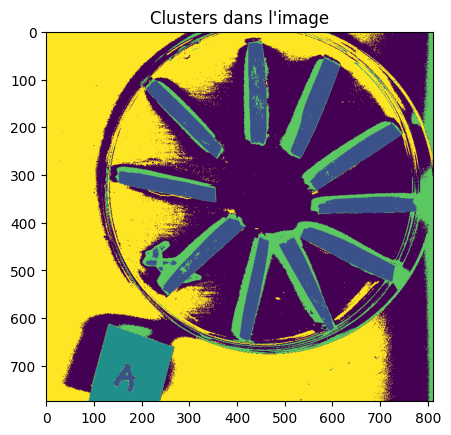

In [18]:
Nb_classes = 5
kmeans()

Avec 5 classes, on a encore le même problème d'avant.

Centres des clusters :  [[167.821786   173.22307376 175.17331389]
 [107.09464896 126.52381364 116.87074447]
 [252.24756648 243.88931259 247.90933266]
 [149.57271988 156.61610302 157.02415453]
 [183.33039256 185.2002127  186.49262496]
 [ 50.41857062 117.14284374 101.31770775]]
Type de l'image de label : int32


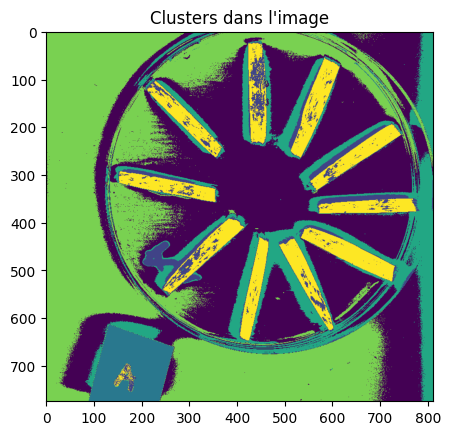

In [19]:
Nb_classes = 6
kmeans()

Avec 6 classes, on a déjà une différenciation des parties sans e avec champignon, mais la classification de la partie avec champignon se mélange avec la classification de certaines ombres des feuilles. En théorie, ça ne pose pas un problème très grand grâce à notre masque, mais comme il s'agit de région très proche de la feuilles et la masque peut avoir des imprécisions, on décide que 6 classes n'est pas encore bon.

Centres des clusters :  [[167.62094058 173.02442355 174.96227964]
 [ 87.94446081 125.81493076 120.28848704]
 [252.24756648 243.88931259 247.90933266]
 [148.15134385 155.57197968 155.86679908]
 [183.27675434 185.16088201 186.45498344]
 [ 46.22873834 115.79632733  98.72047369]
 [167.19469796 108.37375054  39.77009996]]
Type de l'image de label : int32


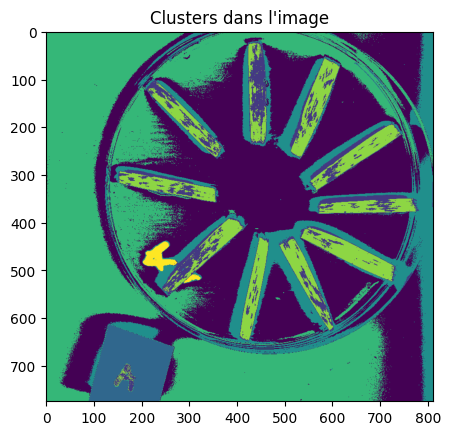

In [20]:
Nb_classes = 7
kmeans()

Avec 7 classes, on a encore le même problème des sombres.

Centres des clusters :  [[167.13296878 172.6522399  174.60472749]
 [ 88.23246396 125.88152029 120.44010997]
 [253.54107634 244.7282682  248.57875344]
 [147.96894628 155.43663379 155.71439138]
 [197.20336808 202.29775461 207.82068966]
 [ 46.36348503 115.83528671  98.78982296]
 [167.19469796 108.37375054  39.77009996]
 [182.1103558  183.90065235 184.9946925 ]]
Type de l'image de label : int32


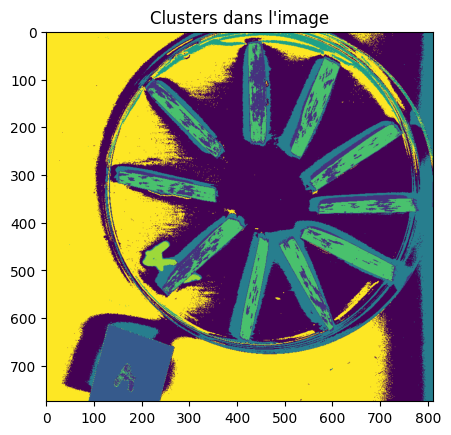

Centres des clusters :  [[168.43108127 173.84709541 175.87577385]
 [ 75.6950923  122.54385424 114.1930888 ]
 [253.55118355 244.73390781 248.57999377]
 [154.8368027  160.70985192 161.51841074]
 [197.34240548 202.45958279 208.01352673]
 [ 42.33738627 114.88917949  96.85545756]
 [167.25516938 108.10954685  39.06159261]
 [182.5026798  184.19673513 185.25877736]
 [128.15336143 142.3002987  141.16293629]]
Type de l'image de label : int32


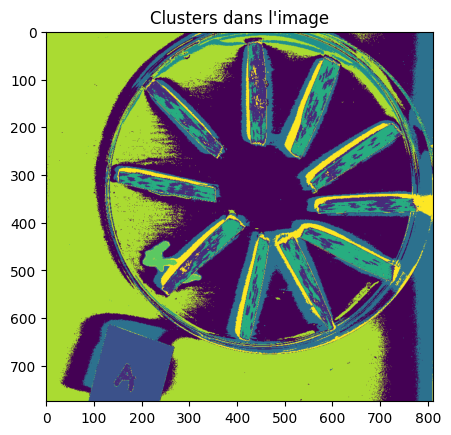

In [24]:
Nb_classes = 8
kmeans()
Nb_classes = 9
kmeans()

On voit que le problème reste encore avec 8 classes, et il se résoudre seulement avec 9. Cependant, 9 classes nous donne déjà une sur-segmentation le l'image par le modèle. Il y a des régions considerables dans les feuilles qui sont classiiés avec une troisième classe, et on veut seulement 2.
Donc, comme on voit qu'on ne peut pas résoudre le problème des sombres en augmantant le nombre de classes, on dépend de notre masque. Comme ça, 7 classes nous semble être approprié. Les parties sont bien classifiés, et ce nombre de classes nous a donnés une segmentation la plus proche du réel en ce qui concerne les parties sans e avec champignon dans le feuilles.

Centres des clusters :  [[167.62094058 173.02442355 174.96227964]
 [ 87.94446081 125.81493076 120.28848704]
 [252.24756648 243.88931259 247.90933266]
 [148.15134385 155.57197968 155.86679908]
 [183.27675434 185.16088201 186.45498344]
 [ 46.22873834 115.79632733  98.72047369]
 [167.19469796 108.37375054  39.77009996]]
Type de l'image de label : int32
Champignon Percentage :  30.59375198022939 %


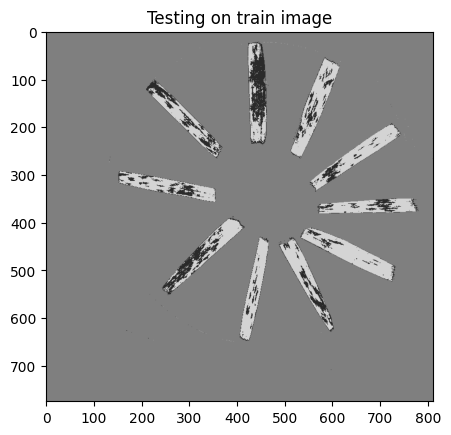

In [44]:
Nb_classes = 7

# Création des clusters (entraînement) sur une image
img_samples = np.reshape(img_bgr,(-1,3))
kmeans = KMeans(n_clusters=Nb_classes, random_state=0).fit(img_samples)
# Affichage des centres de cluster 
print("Centres des clusters : ",kmeans.cluster_centers_)
# Affichage des labels dans l'image d'entraînement
img_labels = np.reshape(kmeans.labels_,(h_img,w_img))
print("Type de l'image de label :",img_labels.dtype)
# Normalisation pour affichage
img_labels_display = (img_labels*255)/(Nb_classes - 1)
img_labels_display = img_labels_display.astype(np.uint8)

img_yuv =  cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YUV)
_,cr,_ = cv2.split(img_yuv)
threshold_level = 116
coords_background = np.column_stack(np.where(cr > threshold_level))

for coord in coords_background:
	img_labels_display[coord[0]][coord[1]] = 127

img_labels_rgb =  cv2.cvtColor(img_labels_display, cv2.COLOR_BGR2RGB)

coords_leafs = np.column_stack(np.where(cr < threshold_level))
positive = 0
negative = 0
for coord in coords_leafs:
	if img_labels_display[coord[0]][coord[1]] == 212:
		positive += 1
	else:
		negative += 1
		
print("Champignon Percentage : ", (negative/(positive + negative)) * 100, "%")

plt.plot()
plt.imshow(img_labels_rgb)
plt.title("Testing on train image")
plt.show()

On a donc obtenu un résultat similaire à celui de la classification de Bayes.